In [2]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations


native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

# Create the DataFrame of the pairs list
pairs_list = pd.read_csv('GRETA/output_TTR/pairs_list_c52_ex1.txt', sep='\\s+')

pairs_list.insert(1, 'ai_resnumber', '')
pairs_list.insert(1, 'ai_resname', '')
pairs_list.insert(4, 'aj_resnumber', '')
pairs_list.insert(4, 'aj_resname', '')

# Separation of the atomtype and the aminoacid number. 
# The atomtype column will be replaced avoiding to create a column and delete this one.
pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
# Replacing the atomtype values with aminoacid number as int
pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
# Conversion from str to int
pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
# Replacing the aminoacid number with the aminoacid name
pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

print(pairs_list)#.to_string())


       ai ai_resname  ai_resnumber     aj aj_resname  aj_resnumber  type  \
0    CA_1        TYR             1   CA_1        TYR             1     1   
1    CA_1        TYR             1   CB_1        TYR             1     1   
2    CA_1        TYR             1  CB_11        SER            11     1   
3    CA_1        TYR             1   CB_2        THR             2     1   
4    CA_1        TYR             1  CD1_1        TYR             1     1   
..    ...        ...           ...    ...        ...           ...   ...   
971   O_7        LEU             7    O_7        LEU             7     1   
972   O_7        LEU             7    O_8        SER             8     1   
973   O_8        SER             8    O_8        SER             8     1   
974   O_8        SER             8    O_9        PRO             9     1   
975   O_9        PRO             9    O_9        PRO             9     1   

           c6           c12     sigma  epsilon  
0    0.007164  3.719267e-05  0.416116 

In [3]:
contacts_histogram = {}
for an in pdb_resids:
    # pdb_resids is the aminocid numbers
    # Selection of the rows contaning the aminoacid number of interest.
    # Note the | and not the &
    is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

    # Filtering a dataframe containing only the aminoacid selected.
    pairs_an = pairs_list[is_an]

    print(f'Total amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
    #print(pairs_an)
    pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
    pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)

    print(pairs_an.to_string())
    an_with_who = pairs_an.an_with_who.value_counts()
    contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
    print(an_with_who.to_string())

#print(contacts_histogram)

Total amount of contacts made by TYR_1: 191
         ai ai_resname  ai_resnumber      aj aj_resname  aj_resnumber  type        c6           c12     sigma  epsilon an_with_who
0      CA_1        TYR             1    CA_1        TYR             1     1  0.007164  3.719267e-05  0.416116    0.345       TYR_1
1      CA_1        TYR             1    CB_1        TYR             1     1  0.008253  4.935589e-05  0.426044    0.345       TYR_1
2      CA_1        TYR             1   CB_11        SER            11     1  0.007220  3.777018e-05  0.416651    0.345      SER_11
3      CA_1        TYR             1    CB_2        THR             2     1  0.006754  3.305778e-05  0.412050    0.345       THR_2
4      CA_1        TYR             1   CD1_1        TYR             1     1  0.004098  1.217173e-05  0.379131    0.345       TYR_1
5      CA_1        TYR             1  CD2_10        TYR            10     1  0.012965  1.218133e-04  0.459358    0.345      TYR_10
6      CA_1        TYR             1   

In [4]:
# Dataframe preparation

histo_df = pd.DataFrame(contacts_histogram)
histo_df[''] = histo_df.index.astype(str)
histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
histo_df.sort_values(by = [''], inplace = True)
histo_df.drop(columns='', inplace=True)
histo_df = histo_df.fillna(0)
histo_df.columns = list(amino_dict_num.values())
print(histo_df.to_string())



        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    58.0   30.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    40.0    59.0
THR_2    30.0   26.0   32.0    6.0    0.0    0.0    0.0    0.0   16.0    22.0    15.0
ILE_3     4.0   32.0   29.0   24.0    4.0    1.0    0.0   12.0    9.0    18.0     0.0
ALA_4     0.0    6.0   24.0   15.0   18.0    2.0   15.0    0.0   10.0     0.0     0.0
ALA_5     0.0    0.0    4.0   18.0   15.0   31.0   14.0    0.0    0.0     0.0     0.0
LEU_6     0.0    0.0    1.0    2.0   31.0   34.0   47.0    5.0    0.0     0.0     4.0
LEU_7     0.0    0.0    0.0   15.0   14.0   47.0   31.0   24.0   10.0     0.0     7.0
SER_8     0.0    0.0   12.0    0.0    0.0    5.0   24.0   20.0   32.0    22.0    29.0
PRO_9     0.0   16.0    9.0   10.0    0.0    0.0   10.0   32.0   25.0    40.0     7.0
TYR_10   40.0   22.0   18.0    0.0    0.0    0.0    0.0   22.0   40.0    57.0    32.0
SER_11   59.0   15.0    0.0    0.0    0.0    4.0    7.

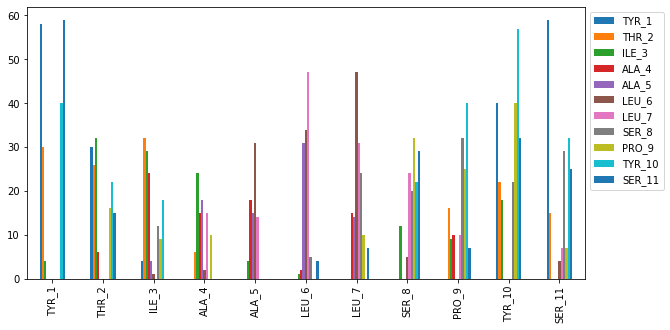

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.show()

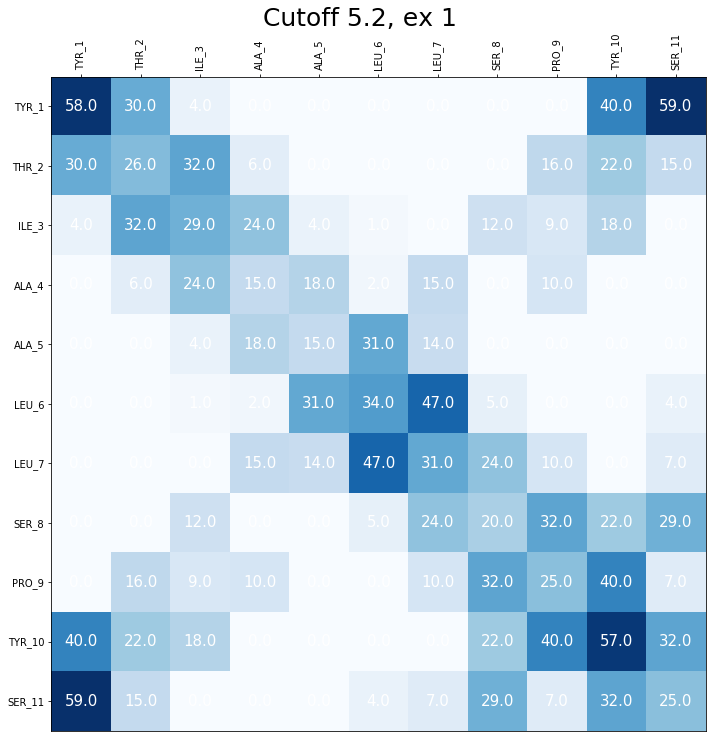

In [6]:
import numpy as np

matrix_df = histo_df.to_numpy()
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df.columns)))
ax.set_yticks(np.arange(len(histo_df.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df.columns))
ax.set_yticklabels(list(histo_df.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df.index)):
    for j in range(len(histo_df.columns)):
        text = ax.text(j,i, matrix_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle('Cutoff 5.2, ex 1', fontsize = 25, y = 1.02)
fig.tight_layout()

In [7]:
# Making a normalized dataframe and matrix
histo_df_norm = histo_df.div(histo_df.max().max())
pd.options.display.float_format = '{:.2f}'.format
print(histo_df_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.98   0.51   0.07   0.00   0.00   0.00   0.00   0.00   0.00    0.68    1.00
THR_2    0.51   0.44   0.54   0.10   0.00   0.00   0.00   0.00   0.27    0.37    0.25
ILE_3    0.07   0.54   0.49   0.41   0.07   0.02   0.00   0.20   0.15    0.31    0.00
ALA_4    0.00   0.10   0.41   0.25   0.31   0.03   0.25   0.00   0.17    0.00    0.00
ALA_5    0.00   0.00   0.07   0.31   0.25   0.53   0.24   0.00   0.00    0.00    0.00
LEU_6    0.00   0.00   0.02   0.03   0.53   0.58   0.80   0.08   0.00    0.00    0.07
LEU_7    0.00   0.00   0.00   0.25   0.24   0.80   0.53   0.41   0.17    0.00    0.12
SER_8    0.00   0.00   0.20   0.00   0.00   0.08   0.41   0.34   0.54    0.37    0.49
PRO_9    0.00   0.27   0.15   0.17   0.00   0.00   0.17   0.54   0.42    0.68    0.12
TYR_10   0.68   0.37   0.31   0.00   0.00   0.00   0.00   0.37   0.68    0.97    0.54
SER_11   1.00   0.25   0.00   0.00   0.00   0.07   0.1

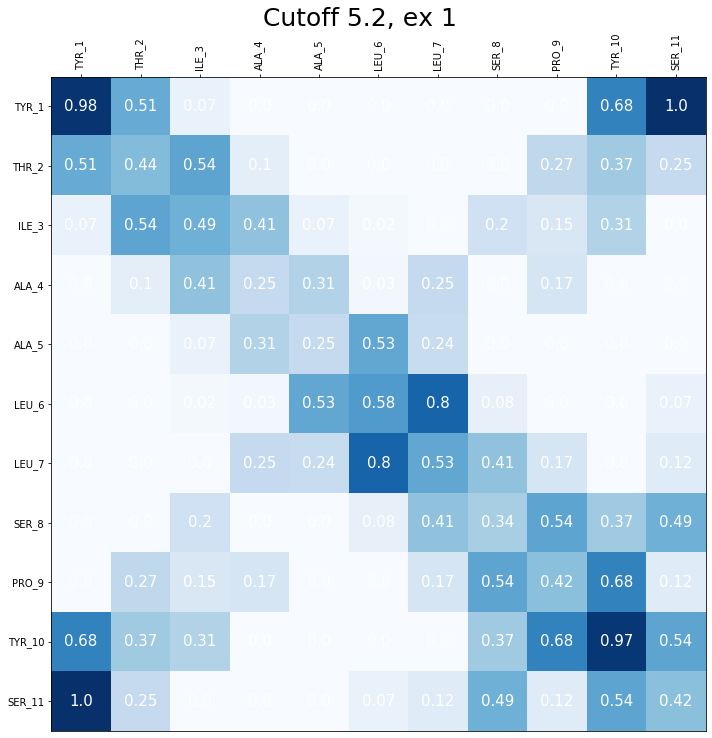

In [8]:
matrix_norm_df = histo_df_norm.to_numpy()
matrix_norm_df = matrix_norm_df.round(decimals = 2)

# plot creation
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_norm_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df_norm.columns)))
ax.set_yticks(np.arange(len(histo_df_norm.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df_norm.columns))
ax.set_yticklabels(list(histo_df_norm.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df_norm.index)):
    for j in range(len(histo_df_norm.columns)):
        text = ax.text(j,i, matrix_norm_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle('Cutoff 5.2, ex 1', fontsize = 25, y = 1.02)
fig.tight_layout()